In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

2025-12-19 16:46:32.118858: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


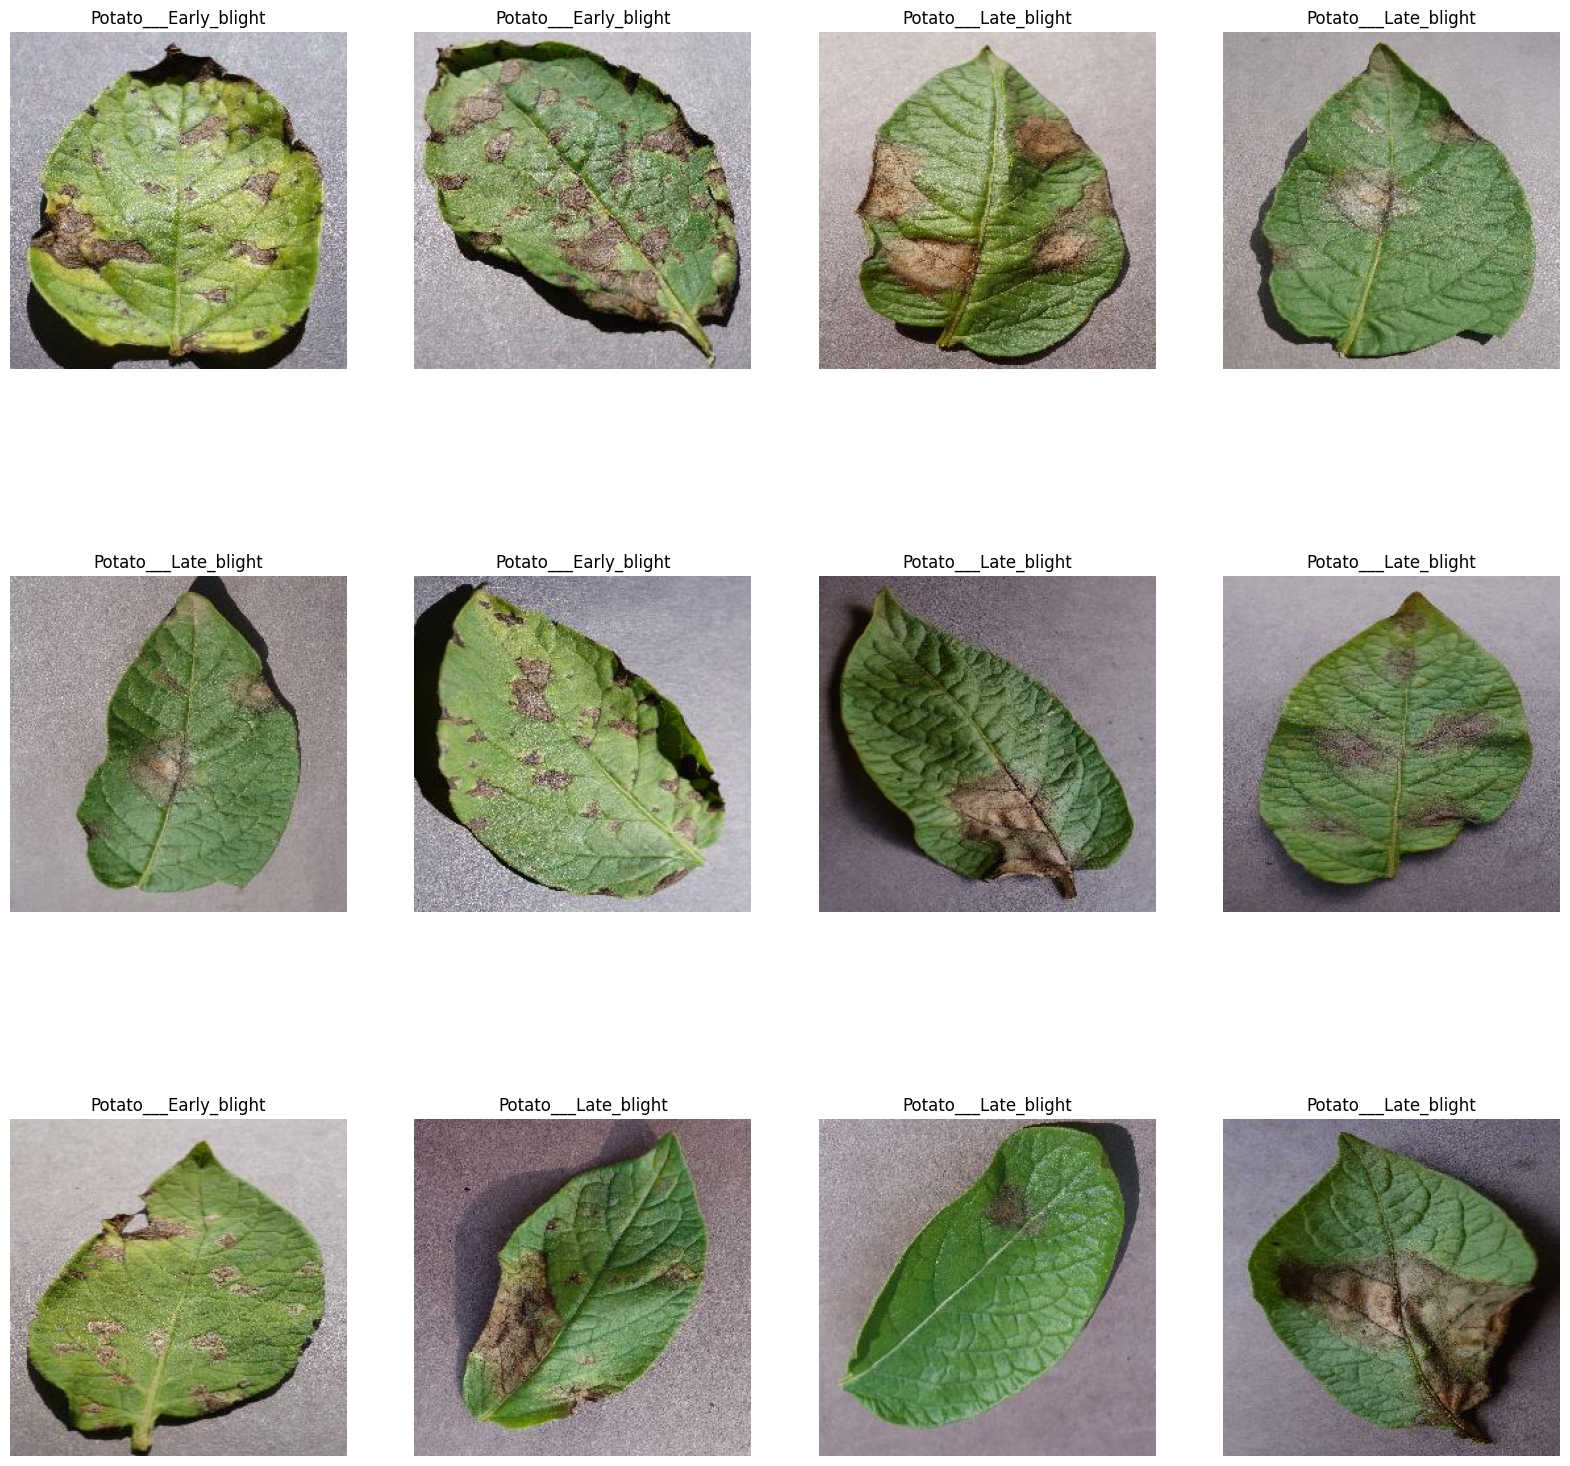

In [8]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in df.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
plt.show()

In [9]:
def partitions(df, train_split=0.8, test_split=0.1, val_split = 0.1, shuffle = True, shuffle_size = 10000):
  df_size = len(df)
  if shuffle:
    df = df.shuffle(shuffle_size, seed=12)

  train_size = int(train_split*df_size)
  val_size = int(val_split*df_size)

  train_df = df.take(train_size)
  val_df = df.skip(train_size).take(val_size)
  test_df = df.skip(train_size).skip(val_size)

  return train_df, val_df, test_df


In [10]:
train_df, val_df, test_df = partitions(df)


In [11]:
print(len(train_df), len(val_df), len(test_df))

54 6 8


In [12]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [13]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [14]:
df_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [19]:
n_classes = 3

model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),  

    resize_rescale,
    df_aug,

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [20]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [22]:
history = model.fit(
    train_df,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_df
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 531ms/step - accuracy: 0.5035 - loss: 0.8963 - val_accuracy: 0.6667 - val_loss: 0.7621
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 539ms/step - accuracy: 0.7350 - loss: 0.6868 - val_accuracy: 0.7812 - val_loss: 0.5593
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - accuracy: 0.8061 - loss: 0.4717 - val_accuracy: 0.8802 - val_loss: 0.3743
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 563ms/step - accuracy: 0.8709 - loss: 0.3336 - val_accuracy: 0.9115 - val_loss: 0.2684
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 564ms/step - accuracy: 0.8958 - loss: 0.2555 - val_accuracy: 0.9219 - val_loss: 0.2279
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 551ms/step - accuracy: 0.8889 - loss: 0.2751 - val_accuracy: 0.7865 - val_loss: 0.5226
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 566ms/step - accuracy: 0.9005 - loss: 0.2546 - val_accuracy: 0.9583 - val_loss: 0.1523
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 573ms/step - accuracy: 0.9242 - loss: 0.1975 - val_accu

In [23]:
scores = model.evaluate(test_df)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8164 - loss: 0.7331


In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

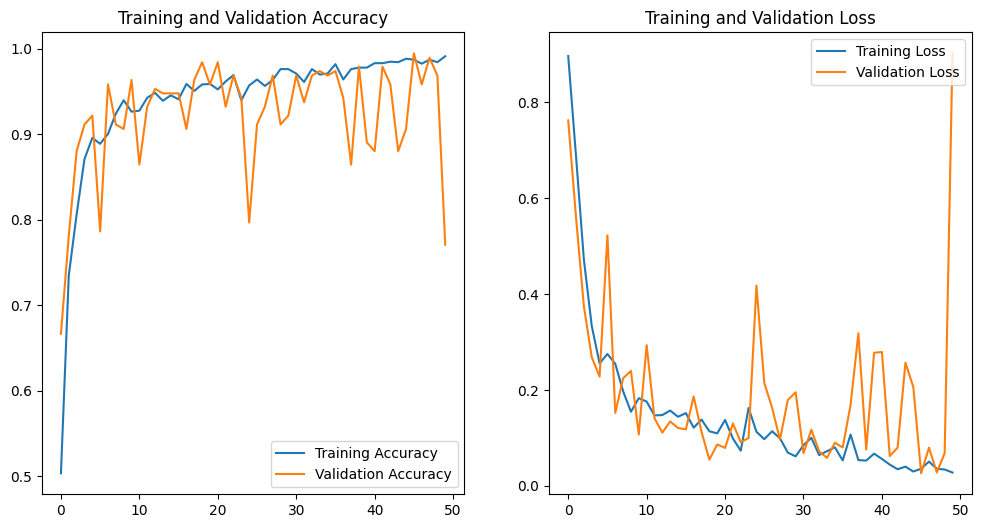

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

first img to predict
Actual Label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Predicted Label: Potato___Early_blight


2025-12-19 17:53:26.541858: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


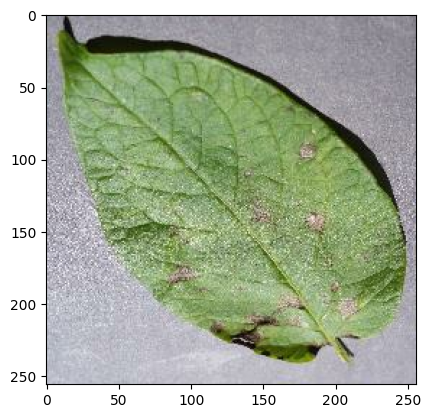

In [30]:
for image_batch, label_batch in test_df.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()

    print("first img to predict")
    plt.imshow(first_image)
    print("Actual Label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [31]:
def predict(model, img):
    img_arr = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_arr =  tf.expand_dims(img_arr, 0)  # Create batch axis
    predictions = model.predict(img_arr)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


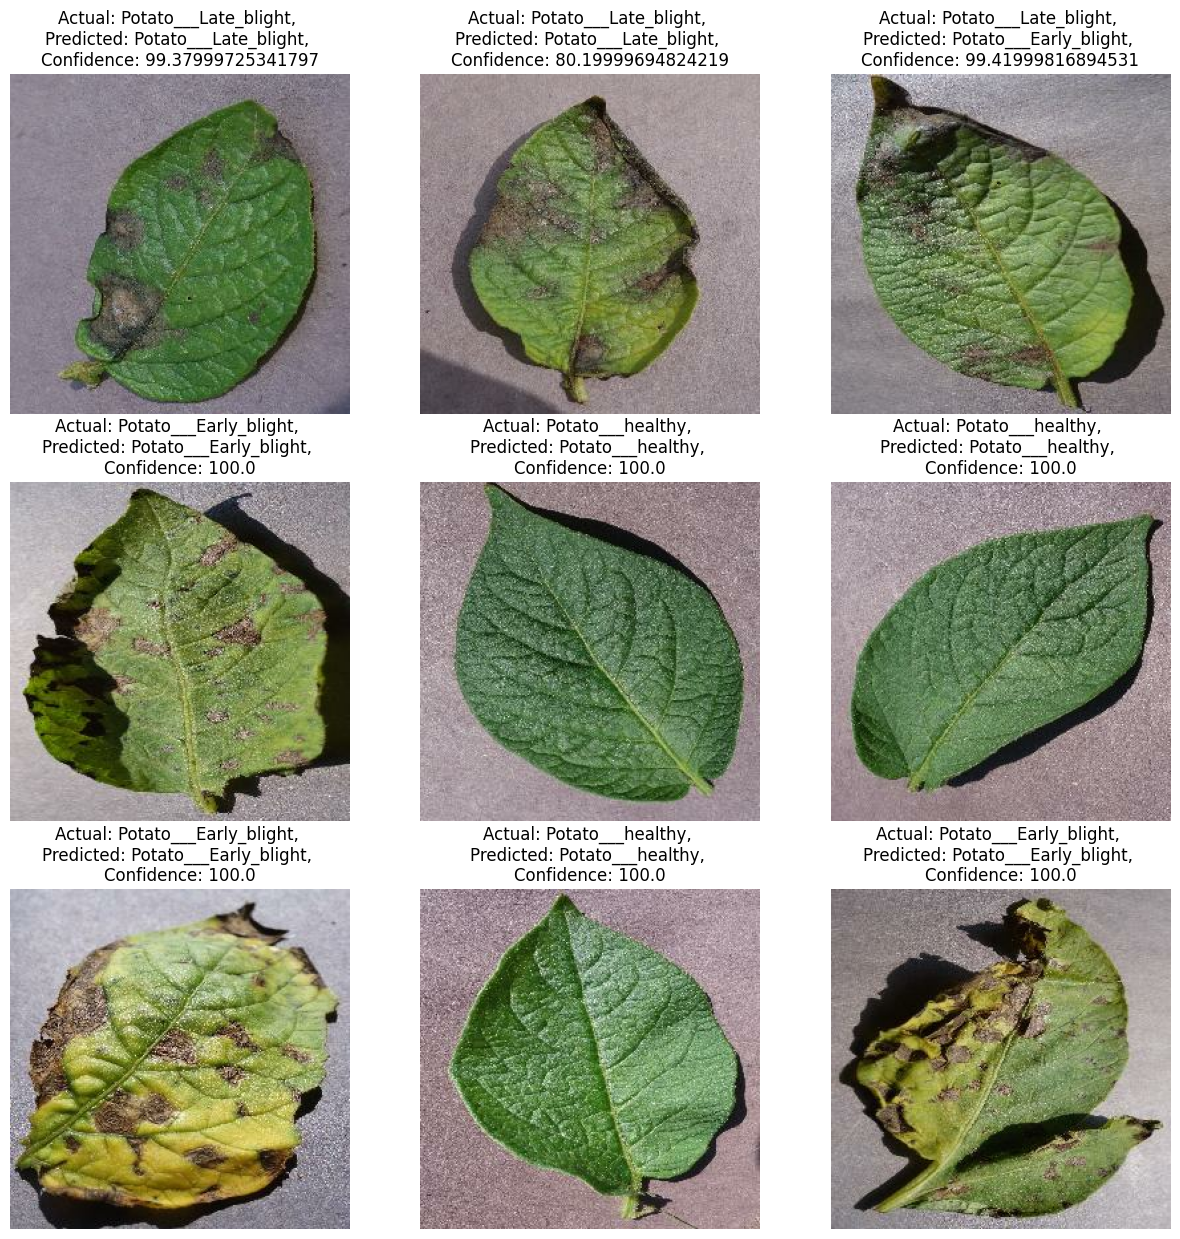

In [34]:
plt.figure(figsize=(15,15))
for images, labels in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}")
        plt.axis("off")



In [37]:
model_version = 1
model.save(f"/Users/ruchikasharma/AaluBimari/models/{model_version}.keras")